# Structure function for inner Orion Nebula

This follows exactly the same steps as for NGC 346

In [ ]:
import numpy as np
from astropy.io import fits

In [2]:
import sys
sys.path.append("../muse-strucfunc")
import strucfunc

In [3]:
hdu = fits.open("data/Orion/DOHha_-040+070.wisomom-mean-xx.fits")

In [4]:
hdu.info()

Filename: data/Orion/DOHha_-040+070.wisomom-mean-xx.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (356, 514)   float32   


In [7]:
vha = hdu[0].data.astype(float)

In [9]:
iha = fits.open(
    "data/Orion/DOHha_-040+070.wisomom-sum-xx.fits"
)[0].data.astype(float)

In [10]:
m = ~np.isfinite(iha * vha) | (iha < 0.0)
iha[m] = 0.0
vha[m] = np.nanmean(vha)
iha /= iha.max()

In [57]:
strucfunc.strucfunc_numba_parallel?

Signature:
strucfunc.strucfunc_numba_parallel(
    vmap,
    dlogr=0.15,
    wmap=None,
    wmin_factor=0.001,
)
Docstring: Calculate structure function via multithreaded numba algorithm
File:      ~/Dropbox/muse-strucfunc/strucfunc.py
Type:      function


In [59]:
sf = strucfunc.strucfunc_numba_parallel(vha, wmap=iha, dlogr=0.05)

In [60]:
sf

{'log10 r': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ]),
 'Sum dv^2': array([5.41907216e+03, 0.00000000e+00, 0.00000000e+00, 2.44343156e+04,
        0.00000000e+00, 0.00000000e+00, 1.34470495e+05, 0.00000000e+00,
        0.00000000e+00, 1.28999278e+05, 2.10739614e+05, 2.67041478e+05,
        5.71519378e+05, 9.31889053e+05, 9.71085992e+05, 1.58714205e+06,
        3.32127020e+06, 3.31354404e+06, 5.44754355e+06, 8.57729189e+06,
        1.48072661e+07, 1.74814859e+07, 2.51645299e+07, 4.05749931e+07,
        5.15730684e+07, 7.60332348e+07, 1.11944715e+08, 1.54991300e+08,
        2.14549435e+08, 2.97966669e+08, 4.38511577e+08, 5.74557142e+08,
        8.40905322e+08, 1.132

In [61]:
good = (~m) & (iha > 0.001)
sf["Unweighted mean velocity"] = np.mean(vha[good])
sig2 = sf["Unweighted sigma^2"] = np.var(vha[good])
v0w = sf["Weighted mean velocity"] = np.average(vha, weights=iha)
sf["Weighted sigma^2"] = np.average((vha - v0w)**2, weights=iha)

In [62]:
{k: sf[k] for k in sf if "sigma" in k or "mean" in k}

{'Unweighted mean velocity': 16.776593419383627,
 'Unweighted sigma^2': 9.375506960018136,
 'Weighted mean velocity': 16.585946220297235,
 'Weighted sigma^2': 9.22861264740973}

In [63]:
import astropy.units as u

In [64]:
D = 0.410 * u.kpc
pix_arcsec = 0.534
pix_pc = (pix_arcsec * (D / u.pc) * u.au).to(u.pc)
pix_pc

<Quantity 0.00106145 pc>

In [65]:
sf["sep, pc"] = 10**sf["log10 r"] * pix_pc.value

In [66]:
import numpy as np


def bfunc00(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = 1.0 / (1.0 + (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

def seeing(r, s0):
    return (np.tanh((r / (2.0 * s0))**2))**2

def bfunc01(r, r0, sig2, m, s0):
    "Structure function with added seeing (scale `s0`)"
    return seeing(r, s0) * bfunc00(r, r0, sig2, m)

def bfunc02(r, r0, sig2, m, s0, noise):
    "Structure function with added seeing (scale `s0`) and noise"
    return seeing(r, s0) * bfunc00(r, r0, sig2, m) + noise


In [67]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set_context("talk")

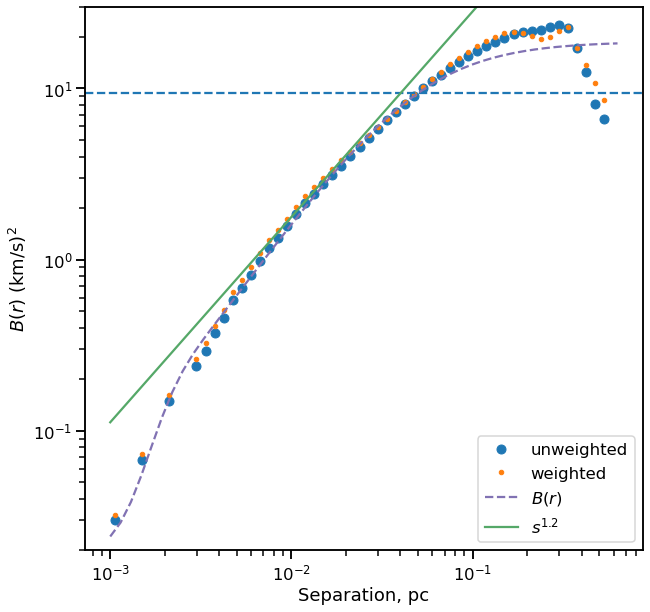

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))
rgrid = np.logspace(
    np.log10(sf["sep, pc"][0]),
    np.log10(sf["sep, pc"][-1]),
    200
)
    
ax.plot(
    "sep, pc", "Unweighted B(r)", data=sf,
    linestyle="none",
    marker="o", label="unweighted",
)
ax.plot(
    "sep, pc", "Weighted B(r)", data=sf,
    linestyle="none",
    marker=".", label="weighted",
)
ax.axhline(sf["Unweighted sigma^2"], linestyle="dashed")

rgrid = np.logspace(-3.0, -0.2)
ax.plot(
    rgrid, 
#    bfunc02(rgrid, r0=0.044, sig2=sig2, m=1.48, s0=0.001, noise=0.019),
    bfunc02(rgrid, r0=0.050, sig2=sig2, m=1.48, s0=0.0009, noise=0.019),
    color="m", linestyle="dashed",
    label=fr"$B(r)$",
)
r0 = 0.04
mm = 1.2
ax.plot(
    rgrid, 
    sig2 * (rgrid / r0)**mm,
    color="g", linestyle="solid",
    label=fr"$s^{{{mm}}}$",
)



ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Separation, pc",
    ylabel=r"$B(r)$ (km/s)$^2$",
    ylim=[2e-2, 30.],
);

In [79]:
import json

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [74]:
jsonfilename = f"orion-strucfunc-ha.json"
with open(jsonfilename, "w") as f:
    json.dump(sf, fp=f, indent=3, cls=MyEncoder)